In [221]:
import os
import sys
import csv
import json
import gzip

import numpy as np
import scipy as sp
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

from tqdm.notebook import tqdm

In [13]:
data_path = '../data'
dataset_path = '../data/faers/drug/datasets/drug_2005-2005'
print(os.path.exists(dataset_path))

dataset_info = json.load(open(os.path.join(dataset_path, 'dataset.json')))
num_reports = dataset_info['reports_by_drugs']['shape'][0]
num_reports

True


219850

|               | Reaction | No Reaction |
|---------------|----------|-------------|
| Indication    | A        | B           |
| No Indication | C        | D           |

PRR = (A/B) / (C/D)


In [34]:
# indications
indication2report = json.load(open(os.path.join(dataset_path, 'indication2report.json')))
print(f"Num indications: {len(indication2report)}")

reaction2report = json.load(open(os.path.join(dataset_path, 'reaction2report.json')))
print(f"Num Reactions: {len(reaction2report)}")

indication_prrs_data = list()
for indication, ind_reports in tqdm(indication2report.items()):
    for reaction, rxn_reports in reaction2report.items():
        A = float(len(set(ind_reports) & set(rxn_reports)))
        B = float(len(ind_reports)-A)
        C = float(len(rxn_reports)-A)
        D = float(num_reports-(A+B+C))
        if B == 0:
            B = 1
        if C == 0:
            C = 1
        PRR = (A/B)/(C/D)
        indication_prrs_data.append([indication, reaction, A, B, C, D, PRR])

indication_prrs = pd.DataFrame(indication_prrs_data, columns=['indication', 'reaction', 'A', 'B', 'C', 'D', 'PRR'])

Num indications: 4196
Num Reactions: 9242


  0%|          | 0/4196 [00:00<?, ?it/s]

In [53]:
indication_prrs[indication_prrs['A'] >= 50].sort_values(by='PRR', ascending=False).head()
# indication_prrs[(indication_prrs['reaction']=='35506628')].sort_values(by='A', ascending=False).head(10)

,indication,reaction,A,B,C,D,PRR
1044818,ABORTION INDUCED,36818629,51.0,168.0,7.0,219624.0,9524.510204
5039133,VULVOVAGINAL MYCOTIC INFECTION,42890298,78.0,235.0,14.0,219523.0,5204.496657
5038030,VULVOVAGINAL MYCOTIC INFECTION,37119780,91.0,222.0,45.0,219492.0,1999.376577
6642,ACCIDENTAL EXPOSURE,43053921,55.0,76.0,119.0,219600.0,1335.471031
1221230,CONTRACEPTION,42889673,89.0,1571.0,19.0,218171.0,650.514892


In [17]:
# load the meddra labels
reaction2label = dict()
with open(os.path.join(data_path, 'meddra_llt_pt_map.txt')) as fh:
    reader = csv.reader(fh, delimiter='|')
    header = next(reader)
    #print(header)
    for row in tqdm(reader):
        data = dict(zip(header, row))
        reaction2label[data['llt_concept_id']] = data['llt_concept_name']
        reaction2label[data['pt_concept_id']] = data['pt_concept_name']

0it [00:00, ?it/s]

In [111]:
# load the rxnorm labels
ingredient2label = dict()
with gzip.open(os.path.join(data_path, 'rxnorm_product_to_ingredient.csv.gz'), 'rt') as fh:
    reader = csv.reader(fh, delimiter=',')
    header = next(reader)
    # print(header)
    for row in tqdm(reader):
        data = dict(zip(header, row))
        ingredient2label[data['ingredient_rx_cui']] = data['ingredient_name']

0it [00:00, ?it/s]

In [97]:
reaction2index = json.load(open(os.path.join(dataset_path, 'reaction2index.json')))
ordered_reactions = [key for key, index in sorted(reaction2index.items(), key=lambda item: item[1])]

indication2index = json.load(open(os.path.join(dataset_path, 'indication2index.json')))
ordered_indications = [key for key, index in sorted(indication2index.items(), key=lambda item: item[1])]

ingredient2index = json.load(open(os.path.join(dataset_path, 'ingredient2index.json')))
ordered_ingredients = [key for key, index in sorted(ingredient2index.items(), key=lambda item: item[1])]

In [100]:
reactions = sp.sparse.load_npz(os.path.join(dataset_path, 'reports_by_reactions.npz'))
print(reactions.shape)
indications = sp.sparse.load_npz(os.path.join(dataset_path, 'reports_by_indications.npz'))
print(indications.shape)
ingredients = sp.sparse.load_npz(os.path.join(dataset_path, 'reports_by_ingredients.npz'))
print(ingredients.shape)

(219850, 9242)
(219850, 4196)
(219850, 1936)


In [114]:
def compute_matrices(m1, m2, num_reports):
    A = (m1.T @ m2).toarray()
    B = (m1.sum(0).T - A).A
    # B[B==0] = 1
    C = (m2.sum(0) - A).A
    # C[C==0] = 1
    D = (num_reports-(A+B+C))
    
    PRR = ((A/B)/(C/D))
    Tc = A/(A+B+C)

    return {
        'A': A,
        'B': B,
        'C': C,
        'D': D,
        'PRR': PRR,
        'Tc': Tc
    }

def build_dataframe(matrices, ordered_m1, m1_name, ordered_m2, m2_name, m12label=None, m22label=None, minA=10):
    
    mask = matrices['A']>=10
    indices = np.where(mask)
    dfdata = {}

    dfdata[m1_name] = [ordered_m1[i] for i in indices[0]]
    if m12label is not None:
        dfdata[f"{m1_name}_label"] = [m12label.get(ordered_m1[i], i) for i in indices[0]]
    
    dfdata[m2_name] = [ordered_m2[i] for i in indices[1]]
    if m22label is not None:
        dfdata[f"{m2_name}_label"] = [m22label.get(ordered_m2[i], i) for i in indices[1]]

    for key, mat in matrices.items():
        dfdata[key] = mat[mask]

    return pd.DataFrame(dfdata)

In [123]:
matrices = compute_matrices(indications, reactions, num_reports)

ind_rxn = build_dataframe(matrices, 
                          ordered_indications, 'indication',
                          ordered_reactions, 'reaction',
                          m22label=reaction2label,
                          minA=10)

# ind_rxn.sort_values(by='Tc', ascending=False).head(10)
ind_rxn[(ind_rxn['reaction']=='35506628')].sort_values(by='Tc', ascending=False).head(10)

/var/folders/l5/4jn07y290nncb4wnyhsq33hh0000gt/T/ipykernel_10182/1102015915.py:9: RuntimeWarning: divide by zero encountered in divide
  PRR = ((A/B)/(C/D))


,indication,reaction,reaction_label,A,B,C,D,PRR,Tc
7150,DIABETES MELLITUS INSULIN-DEPENDENT,35506628,Hyperglycaemia,31,573,813,218433,14.535661,0.021877
1181,DIABETES MELLITUS,35506628,Hyperglycaemia,66,3116,778,215890,5.877592,0.016667
6349,SCHIZOPHRENIA,35506628,Hyperglycaemia,29,2281,815,216725,3.380836,0.009280
11897,URINARY TRACT INFECTION,35506628,Hyperglycaemia,13,577,831,218429,5.922115,0.009148
9817,ACUTE LYMPHOCYTIC LEUKAEMIA,35506628,Hyperglycaemia,10,492,834,218514,5.325349,0.007485
3991,DIABETES MELLITUS NON-INSULIN-DEPENDENT,35506628,Hyperglycaemia,38,4340,806,214666,2.331965,0.007330
8082,BIPOLAR DISORDER,35506628,Hyperglycaemia,19,2411,825,216595,2.068954,0.005837
2240,ARTHRALGIA,35506628,Hyperglycaemia,20,2849,824,216157,1.841534,0.005416
5865,HYPERTENSION,35506628,Hyperglycaemia,43,7226,801,211780,1.573341,0.005328
1605,ARTHRITIS,35506628,Hyperglycaemia,41,7169,803,211837,1.508730,0.005117


In [124]:
matrices = compute_matrices(indications, ingredients, num_reports)

ind_ing = build_dataframe(matrices, 
                          ordered_indications, 'indication',
                          ordered_ingredients, 'ingredient',
                          m22label=ingredient2label,
                          minA=10)

ind_ing.sort_values(by='Tc', ascending=False).head(10)

/var/folders/l5/4jn07y290nncb4wnyhsq33hh0000gt/T/ipykernel_10182/1102015915.py:9: RuntimeWarning: divide by zero encountered in divide
  PRR = ((A/B)/(C/D))


,indication,ingredient,ingredient_label,A,B,C,D,PRR,Tc
8429,FABRY'S DISEASE,338817,agalsidase beta,281,1,0,219568,inf,0.996454
7988,GAUCHER'S DISEASE,84959,imiglucerase,105,10,1,219734,2.307207e+06,0.905172
9323,MUCOPOLYSACCHARIDOSIS I,392509,laronidase,64,0,13,219773,inf,0.831169
7987,SKIN WRINKLING,1712,botulinum toxin type A,292,6,162,219390,6.590728e+04,0.634783
1755,DIABETES MELLITUS NON-INSULIN-DEPENDENT,60548,exenatide,3194,1184,707,214765,8.194591e+02,0.628122
3130,PULMONARY HYPERTENSION,75207,bosentan,439,264,48,219099,7.590314e+03,0.584554
7611,HAEMOPHILIA,1670383,factor IX complex,189,130,8,219523,3.989408e+04,0.577982
5531,ABORTION INDUCED,42331,misoprostol,205,14,154,219477,2.086864e+04,0.549598
9034,HYPERPARATHYROIDISM SECONDARY,407990,cinacalcet,123,76,34,219617,1.045391e+04,0.527897
8131,ACROMEGALY,278739,pegvisomant,34,27,5,219784,5.535301e+04,0.515152


In [126]:
matrices = compute_matrices(ingredients, reactions, num_reports)

ing_rxn = build_dataframe(matrices, 
                          ordered_ingredients, 'ingredient',
                          ordered_reactions, 'reaction',
                          m12label=ingredient2label,
                          m22label=reaction2label,
                          minA=10)

ing_rxn.sort_values(by='Tc', ascending=False).head(10)
ing_rxn[(ing_rxn['reaction']=='35506628')].sort_values(by='PRR', ascending=False).head(10)

/var/folders/l5/4jn07y290nncb4wnyhsq33hh0000gt/T/ipykernel_10182/1102015915.py:9: RuntimeWarning: divide by zero encountered in divide
  PRR = ((A/B)/(C/D))


,ingredient,ingredient_label,reaction,reaction_label,A,B,C,D,PRR,Tc
30666,228476,gatifloxacin,35506628,Hyperglycaemia,37,277,807,218729,36.203853,0.033006
3776,274783,insulin glargine,35506628,Hyperglycaemia,81,2038,763,216968,11.301914,0.028105
18005,253182,"insulin, regular, human",35506628,Hyperglycaemia,23,643,821,218363,9.513772,0.015467
13236,51428,"insulin aspart, human",35506628,Hyperglycaemia,15,468,829,218538,8.449244,0.011433
2363,61381,olanzapine,35506628,Hyperglycaemia,72,2482,772,216524,8.136160,0.021648
20668,52105,lithium citrate,35506628,Hyperglycaemia,14,527,830,218479,6.992767,0.010212
17897,1605101,insulin isophane,35506628,Hyperglycaemia,19,727,825,218279,6.914761,0.012094
11531,4815,glyburide,35506628,Hyperglycaemia,35,1397,809,217609,6.739070,0.015618
25734,9071,quinine,35506628,Hyperglycaemia,10,459,834,218547,5.709080,0.007675
22080,7213,ipratropium,35506628,Hyperglycaemia,20,1036,824,217970,5.106693,0.010638


In [190]:
matrices = compute_matrices(ingredients, ingredients, num_reports)

ing_ing = build_dataframe(matrices,
                          ordered_ingredients, 'ingredient1',
                          ordered_ingredients, 'ingredient2',
                          m12label=ingredient2label,
                          m22label=ingredient2label,
                          minA=10)

ing_ing = ing_ing[ing_ing['ingredient1'] != ing_ing['ingredient2']]
ing_ing.sort_values(by='Tc', ascending=False).head(10)

/var/folders/l5/4jn07y290nncb4wnyhsq33hh0000gt/T/ipykernel_10182/1102015915.py:9: RuntimeWarning: divide by zero encountered in divide
  PRR = ((A/B)/(C/D))


,ingredient1,ingredient1_label,ingredient2,ingredient2_label,A,B,C,D,PRR,Tc
31216,1670383,factor IX complex,4257,factor VIII,155,42,14,219639,57898.035714,0.734597
31612,4257,factor VIII,1670383,factor IX complex,155,14,42,219639,57898.035714,0.734597
33669,4492,fluorouracil,6313,leucovorin,770,887,312,217881,606.222249,0.391061
35381,6313,leucovorin,4492,fluorouracil,770,312,887,217881,606.222249,0.391061
21458,343047,atazanavir,85762,ritonavir,280,191,363,219016,884.491945,0.335731
32409,85762,ritonavir,343047,atazanavir,280,363,191,219016,884.491945,0.335731
12684,1605101,insulin isophane,253182,"insulin, regular, human",318,428,348,218756,467.050757,0.290676
12738,253182,"insulin, regular, human",1605101,insulin isophane,318,348,428,218756,467.050757,0.290676
22176,10171,sulfadiazine,9010,pyrimethamine,11,11,16,219812,13738.250000,0.289474
22177,9010,pyrimethamine,10171,sulfadiazine,11,16,11,219812,13738.250000,0.289474


In [193]:
# build datafraem to look at confounding by indication
ind_keep = ['ingredient', 
        'ingredient_label', 
        'reaction', 
        'reaction_label',
        'indication',
        'PRR_ing_rxn',
        'PRR_ind_ing',
        'PRR_ind_rxn']
ind_merged = ing_rxn.merge(ind_ing, 
                            on=('ingredient', 'ingredient_label'), 
                            suffixes=('_ing_rxn', '_ind_ing')
                          ).merge(ind_rxn,
                            on=('indication', 'reaction', 'reaction_label'),
                            suffixes=('', '_ind_rxn'))

ind_merged.rename(columns={'PRR': 'PRR_ind_rxn'}, inplace=True)
ind_reduced = ind_merged[ind_keep]
# reduced[reduced['reaction']=='35506628'].head()

(1273, 8)


SignificanceResult(statistic=0.8599305837050616, pvalue=0.0)

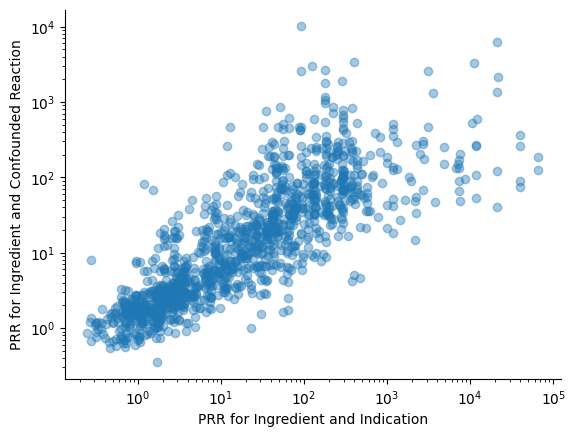

In [219]:
# we only care about whent the relationship between the indication and the reaction is high
ind_rxn_high = ind_reduced[ind_reduced['PRR_ind_rxn'] > 50]
print(ind_rxn_high.shape)

plt.scatter(ind_rxn_high['PRR_ind_ing'], ind_rxn_high['PRR_ing_rxn'], alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('PRR for Ingredient and Indication')
plt.ylabel('PRR for Ingredient and Confounded Reaction')
sns.despine()

sp.stats.spearmanr(ind_rxn_high['PRR_ind_ing'], ind_rxn_high['PRR_ing_rxn'])

In [208]:
# build datafraem to look at confounding by co-prescription
ing_keep = ['ingredient1', 
        'ingredient1_label', 
        'ingredient2', 
        'ingredient2_label',
        'reaction',
        'reaction_label',
        'PRR_ing1_rxn',
        'PRR_ing1_ing2',
        'PRR_ing2_rxn']
ing_merged = ing_rxn.merge(ing_ing, 
                            left_on=('ingredient', 'ingredient_label'), 
                            right_on=('ingredient1', 'ingredient1_label'),
                            suffixes=('_ing1_rxn', '_ing1_ing2')
                        )
ing_merged = ing_merged.drop(['ingredient', 'ingredient_label'], axis=1)

ing_merged = ing_merged.merge(ing_rxn,
                                left_on=('ingredient2', 'ingredient2_label', 'reaction', 'reaction_label'),
                                right_on=('ingredient', 'ingredient_label', 'reaction', 'reaction_label'))
ing_merged = ing_merged.drop(['ingredient', 'ingredient_label'], axis=1)
ing_merged.rename(columns={'PRR': 'PRR_ing2_rxn'}, inplace=True)
ing_reduced = ing_merged[ing_keep]
# ing_reduced[ing_reduced['reaction']=='35506628'].head()
ing_reduced.head()

,ingredient1,ingredient1_label,ingredient2,ingredient2_label,reaction,reaction_label,PRR_ing1_rxn,PRR_ing1_ing2,PRR_ing2_rxn
0,10379,testosterone,435,albuterol,35708202,Nausea,1.187408,2.396465,1.110228
1,10379,testosterone,140587,celecoxib,35708202,Nausea,1.187408,1.913254,0.917289
2,10379,testosterone,10737,trazodone,35708202,Nausea,1.187408,6.085078,1.619367
3,10379,testosterone,32968,clopidogrel,35708202,Nausea,1.187408,2.694545,0.902307
4,10379,testosterone,5487,hydrochlorothiazide,35708202,Nausea,1.187408,3.456642,1.633227


(1418, 9)


SignificanceResult(statistic=0.8274723968001253, pvalue=0.0)

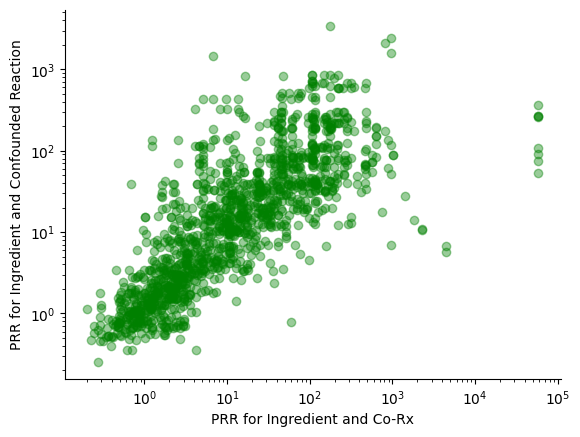

In [231]:
# we only care about whent the relationship between the co-prescription and the reaction is high
# ing_rxn_high = ing_reduced[(ing_reduced['PRR_ing2_rxn'] < 2) & (ing_reduced['PRR_ing2_rxn'] > 0.5)]
ing_rxn_high = ing_reduced[ing_reduced['PRR_ing2_rxn'] > 50]
print(ing_rxn_high.shape)

plt.scatter(ing_rxn_high['PRR_ing1_ing2'], ing_rxn_high['PRR_ing1_rxn'], alpha=0.4, color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('PRR for Ingredient and Co-Rx')
plt.ylabel('PRR for Ingredient and Confounded Reaction')
sns.despine()

sp.stats.spearmanr(ing_rxn_high['PRR_ing1_ing2'], ing_rxn_high['PRR_ing1_rxn'])